# The climate hazards infrared precipitation with stations — a new environmental record for monitoring extremes (CHIRPS data set)

## Overview

- **Key ideas:**
    - Intensive operations that use a lot of RAM memory. Run this notebook inside aerossol server.
    - Chirps is produced at 0.05 x 0.05 degree spatial resolution.
    - Explore single global file.
    - Maps for long term means and standard deviations of South American rainfall (1981 - 2015).
    - Explore monotonic linear long term trends by means of ordinary least squares (OLS) of rainfall for South America in time range 1981 - 2015 without investigating statistical significance of these trends.
    - Regrid and export precipitation data in the same spatial and temporal grid of GIMMS NDVI 3g data set.
- **References:**
    - [CHIRPS FAQ](https://wiki.chc.ucsb.edu/CHIRPS_FAQ).
    - [Paper: The climate hazards infrared precipitation with stations — a new environmental record for monitoring extremes](https://www.nature.com/articles/sdata201566).
    - [Website: CHIRPS: Rainfall Estimates from Rain Gauge and Satellite Observations](https://www.chc.ucsb.edu/data/chirps).

## Initial setup

In [1]:
# Load packages.
import os
import sys
import glob
import warnings
import scipy

import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import cartopy.crs as ccrs

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from dask.diagnostics import ProgressBar

warnings.filterwarnings("ignore")
xr.set_options(display_style="text")
%matplotlib inline

In [2]:
print(">>> Versions:")
print("* numpy:", np.__version__)
print("* xarray:", xr.__version__)
print("\n>>> Computer:")
!echo "* Hostname: ${HOSTNAME}"
!echo "* User: ${USER}"
!echo "* Directory: $(pwd)"
!echo "* Date: $(date)"
!echo "* CPUs: $(nproc)"

>>> Versions:
* numpy: 1.19.1
* xarray: 0.16.0

>>> Computer:
* Hostname: n008
* User: sandroal
* Directory: /work/sandroal/notebooks/single_variables
* Date: Sat Nov 14 18:14:21 BRST 2020
* CPUs: 40


In [3]:
%%time

# My repository.
repository = "/work/sandroal/cdlearn/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn

CPU times: user 1.77 s, sys: 384 ms, total: 2.16 s
Wall time: 3.03 s


In [4]:
# Main directory.
MAIN_FOLDER = "/work/sandroal/data_sets/CHIRPS/GLOBAL_DAILY_005DEG/"

# Map borders for South America.
loni, lonf, lati, latf = -90, -30, -60, 20

# Final results.
save_fig = True

# Data files location.
FIG_FOLDER = "/work/sandroal/images/single_variables/"

In [5]:
# One file for each year (2001 - 2018). 
FILES_PATHS = sorted(glob.glob(MAIN_FOLDER + "*nc"))

# Show some data files paths.
print(">>> Number of files:", len(FILES_PATHS))
FILES_PATHS[-5:]

>>> Number of files: 40


['/work/sandroal/data_sets/CHIRPS/GLOBAL_DAILY_005DEG/chirps-v2.0.2016.days_p05.nc',
 '/work/sandroal/data_sets/CHIRPS/GLOBAL_DAILY_005DEG/chirps-v2.0.2017.days_p05.nc',
 '/work/sandroal/data_sets/CHIRPS/GLOBAL_DAILY_005DEG/chirps-v2.0.2018.days_p05.nc',
 '/work/sandroal/data_sets/CHIRPS/GLOBAL_DAILY_005DEG/chirps-v2.0.2019.days_p05.nc',
 '/work/sandroal/data_sets/CHIRPS/GLOBAL_DAILY_005DEG/chirps-v2.0.2020.days_p05.nc']

## Explore single global file

In [6]:
%%time

# Random choice of a file.
RFP = np.random.choice(FILES_PATHS)
DS = xr.open_dataset(RFP, chunks={})

# Show it.
print(">>> Size in GB:", DS.nbytes / 1e9, " (a lot!) \n")
print(DS)

>>> Size in GB: 21.081639728  (a lot!) 

<xarray.Dataset>
Dimensions:    (latitude: 2000, longitude: 7200, time: 366)
Coordinates:
  * latitude   (latitude) float32 -49.975 -49.925 -49.875 ... 49.924995 49.975
  * longitude  (longitude) float32 -179.975 -179.925 ... 179.92499 179.975
  * time       (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2004-12-31
Data variables:
    precip     (time, latitude, longitude) float32 dask.array<chunksize=(366, 2000, 7200), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-11-21
    creator_name:      Pete Peterson
    creator_email:     pete@geog.ucsb.edu
    institution:       Climate Hazards Group.  University of California at Sa...
    documentation:     http://pubs.usgs.gov/ds/832/
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:  

In [7]:
%%time

# Annual sum.
DS = DS.sum("time")

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.57 ms


**Danger zone! A lot of ram is required here!**

In [8]:
# Load into memory.
with ProgressBar():
    DS = DS.compute()

[########################################] | 100% Completed |  1min 30.0s


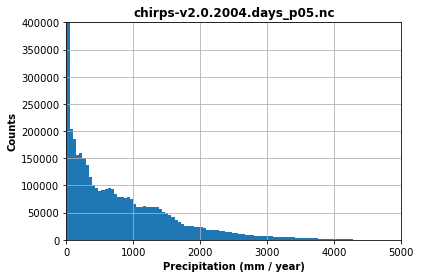

In [9]:
plt.hist(DS.precip.values.flatten(), bins=200)
plt.xlabel("Precipitation (mm / year)", weight="bold")
plt.ylabel("Counts", weight="bold")
plt.title(os.path.basename(RFP), weight="bold")
plt.ylim((0.0e6, 0.4e6))
plt.xlim((0, 5000))
plt.grid();

CPU times: user 12.4 s, sys: 864 ms, total: 13.2 s
Wall time: 13.3 s


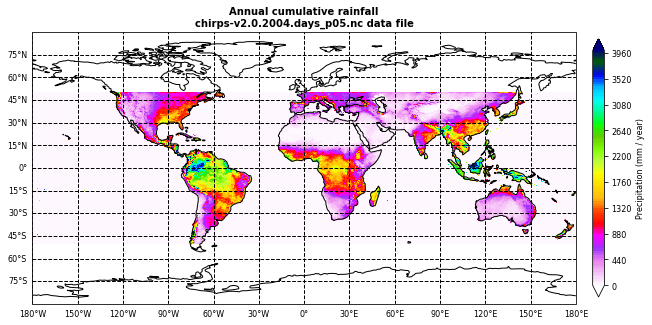

In [10]:
%%time

# Set figure size, projection, and extent.
fig = plt.figure(figsize=(12, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90]) 

# Add coastlines and formatted gridlines.
ax.coastlines(resolution="110m", linewidth=1)
gl = ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True, 
    linewidth=1, 
    color="black", 
    linestyle="--"
)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180 + 30, 30))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90 + 15, 15))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {"size": 8, "color": "black"}
gl.ylabel_style = {"size": 8, "color": "black"}

# Draw the plot.
p = DS.precip.plot(
    ax=ax,
    vmin=0,
    vmax=4000,
    levels=np.arange(0, 4000 + 40, 40),
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)

# Adjustments.
plt.title(f"Annual cumulative rainfall\n" + os.path.basename(RFP) + " data file", 
          weight="bold", size=10)
cb = plt.colorbar(
    mappable=p, 
    ax=ax, 
    orientation="vertical", 
    pad=0.025, 
    shrink=0.95,
    extend="both"
)
cb.set_label("Precipitation (mm / year)", size=8)
cb.ax.tick_params(labelsize=8)

## South America data

In [11]:
%%time

DS = xr.open_mfdataset(
    paths=FILES_PATHS[:35], # 1981 - 2015
    chunks={},
    concat_dim="time"
)

# Rename coordinates.
DS = DS.rename(
    name_dict={"precip": "precipitation", "latitude": "lat", "longitude": "lon"}
)

# South America .
DS = DS.sel(lat=slice(lati, latf), lon=slice(loni, lonf))

# My ninja way.
DS = cdlearn.utils.organize_data(DS)

# Cumulative values for 15-day time step.
DS = DS.resample({"time": "SMS"}, keep_attrs=True).sum("time", keep_attrs=True)

# Update attributes of precipitation variable.
DS["precipitation"] = DS.precipitation.assign_attrs(
    {"units": "mm/15-day", "time_step": "15-day"}
)

# Data size.
print(">>> Size in GB:", DS.nbytes / 1e9, "(a lot!)\n")

# Show it.
print(DS)

>>> Size in GB: 5.64481712 (a lot!)

<xarray.Dataset>
Dimensions:        (lat: 1400, lon: 1200, time: 840)
Coordinates:
  * time           (time) datetime64[ns] 1981-01-01 1981-01-15 ... 2015-12-15
  * lat            (lat) float32 -49.975 -49.925 -49.875 ... 19.924995 19.974998
  * lon            (lon) float32 -89.975006 -89.925 ... -30.074997 -30.02501
Data variables:
    precipitation  (time, lat, lon) float32 dask.array<chunksize=(1, 1400, 1200), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-11-20
    creator_name:      Pete Peterson
    creator_email:     pete@geog.ucsb.edu
    institution:       Climate Hazards Group.  University of California at Sa...
    documentation:     http://pubs.usgs.gov/ds/832/
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           tim

**Danger zone! A lot of ram is required here!**

In [12]:
# Load into memory.
with ProgressBar():
    DS = DS.compute()

[########################################] | 100% Completed |  5min 26.8s


## Summary statistics

CPU times: user 28.3 s, sys: 2.09 s, total: 30.4 s
Wall time: 30.4 s


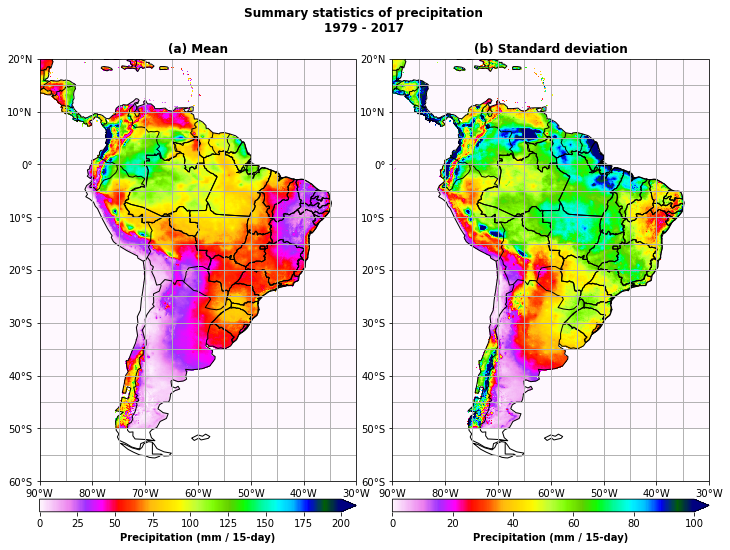

In [13]:
%%time

# Maps.
axgr = cdlearn.maps.south_america(
    figsize=(12, 13), 
    nrows_ncols=(1, 2),
    axes_pad=0.50,
    suptitle="Summary statistics of precipitation\n1979 - 2017",    
    suptitle_y=0.80,
    titles=["(a) Mean", "(b) Standard deviation"],
    cbar_mode="each",
    cbar_location="bottom"
)

# Plot mean results.
plotmap = DS.precipitation.mean("time").plot(
    ax=axgr[0],
    vmin=0,
    vmax=200,
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)  

# Color bar.
cb = plt.colorbar(
    plotmap, 
    cax=axgr.cbar_axes[0], 
    orientation="horizontal", 
    extend="max",
    pad=0.50
)    
cb.set_label("Precipitation (mm / 15-day)", weight="bold")

# Plot deviation results.
plotmap = DS.precipitation.std("time").plot(
    ax=axgr[1],
    vmin=0,
    vmax=100,
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)    

# Color bar.
cb = plt.colorbar(
    plotmap, 
    cax=axgr.cbar_axes[1], 
    orientation="horizontal", 
    extend="max"  
)    
_ = cb.set_label("Precipitation (mm / 15-day)", weight="bold")

## Long term trends

In [14]:
# Slope, intercept, r value, p value, and standard error for linear regression. 
DS_TRENDS = cdlearn.statistics.linear_regression(
    data_set=DS,
    var_code="precipitation", 
    verbose=True
)

>>> Loop over grid points ...


 99% (1679848 of 1680000) |############# | Elapsed Time: 0:11:52 ETA:   0:00:00

CPU times: user 596 ms, sys: 12 ms, total: 608 ms
Wall time: 605 ms


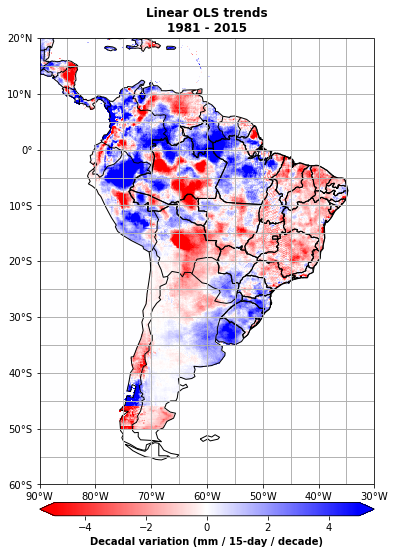

In [15]:
%%time

# Maps.
axgr = cdlearn.maps.south_america(
    figsize=(6, 12), 
    nrows_ncols=(1, 1),
    axes_pad=0.50,
    titles=["Linear OLS trends\n1981 - 2015"],
    cbar_mode="each",
    cbar_location="bottom"
)

# Plot slopes.
plotmap = (240 * DS_TRENDS.slopes).plot(
    ax=axgr[0],
    vmin=-5,
    vmax=5,
    cmap=plt.cm.bwr_r,
    add_colorbar=False,
    add_labels=False
)  

# Color bar.
cb = plt.colorbar(
    plotmap, 
    cax=axgr.cbar_axes[0], 
    orientation="horizontal", 
    extend="both",
    pad=0.50
)    
_ = cb.set_label("Decadal variation (mm / 15-day / decade)", weight="bold")

## Regrid and export data

In [16]:
%%time 

# Load NDVI data into memory.
DS_NDVI = xr.open_dataset(
    filename_or_obj="/work/sandroal/data_sets/GIMMS/ppdata_ndvi.nc"
).load()

# Show it.
print(DS_NDVI)

<xarray.Dataset>
Dimensions:    (lat: 960, lon: 720, time: 828)
Coordinates:
    land_mask  (lat, lon) bool False False False False ... False False False
  * lon        (lon) float64 -89.96 -89.88 -89.79 ... -30.21 -30.13 -30.04
  * lat        (lat) float64 -59.96 -59.88 -59.79 -59.71 ... 19.79 19.88 19.96
  * time       (time) datetime64[ns] 1981-07-01 1981-07-15 ... 2015-12-15
Data variables:
    ndvi       (time, lat, lon) float32 -0.3 -0.3 -0.3 -0.3 ... -0.3 -0.3 -0.3
Attributes:
    FileName:              ndvi3g_geo_v1_1981_0712.nc4
    Institution:           NASA/GSFC GIMMS
    Data:                  NDVI3g version 1
    Reference:             1. Pinzon, J.E.; Tucker, C.J.                     ...
    CommentsVersion1:      version1 includes two major fixes (a and b), and t...
    Temporalrange:         1981-07-01 -> 2015-12-31
    Year:                  1981.0
    RangeSemester:         Jul 1 - Dec 31 (7:0.5:12.5)
    SpatialResolution:     1/12 x 1/12 degrees
    TemporalResolut

In [17]:
# In accordance with GIMMS NDVI 3g original spatial grid.
NEW_GRID = xr.Dataset(
    coords={"lat": (["lat"], DS_NDVI.lat.values), 
            "lon": (["lon"], DS_NDVI.lon.values)}
)

# Show it.
print(NEW_GRID)

<xarray.Dataset>
Dimensions:  (lat: 960, lon: 720)
Coordinates:
  * lat      (lat) float64 -59.96 -59.88 -59.79 -59.71 ... 19.79 19.88 19.96
  * lon      (lon) float64 -89.96 -89.88 -89.79 -89.71 ... -30.21 -30.13 -30.04
Data variables:
    *empty*


In [18]:
%%time

# Regridder object.
REGRIDDER = xe.Regridder(
    ds_in=DS,
    ds_out=NEW_GRID,
    method="bilinear",
    periodic=False, # Not global data!
    filename="chirps_to_gimms_regriddrer.nc",
    reuse_weights=True
)

Create weight file: chirps_to_gimms_regriddrer.nc
CPU times: user 36.1 s, sys: 1.24 s, total: 37.3 s
Wall time: 38.1 s


In [19]:
%%time

# Regrid data.
DS_REG = REGRIDDER(DS, keep_attrs=True)

# Show it.
print(DS_REG)

using dimensions ('lat', 'lon') from data variable precipitation as the horizontal dimensions for this dataset.
<xarray.Dataset>
Dimensions:        (lat: 960, lon: 720, time: 840)
Coordinates:
  * time           (time) datetime64[ns] 1981-01-01 1981-01-15 ... 2015-12-15
  * lon            (lon) float64 -89.96 -89.88 -89.79 ... -30.21 -30.13 -30.04
  * lat            (lat) float64 -59.96 -59.88 -59.79 ... 19.79 19.88 19.96
Data variables:
    precipitation  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-11-20
    creator_name:      Pete Peterson
    creator_email:     pete@geog.ucsb.edu
    institution:       Climate Hazards Group.  University of California at Sa...
    documentation:     http://pubs.usgs.gov/ds/832/
    reference:         Funk, C.C., Peterson, P.J., Landsf

In [20]:
%%time

# Export data.
DS_REG, _ = xr.align(DS_REG, DS_NDVI)
DS_REG = DS_REG.assign_coords({"land_mask": DS_NDVI.land_mask})
ppdata_fp = "/work/sandroal/data_sets/CHIRPS/ppdata_precipitation.nc"
DS_REG.to_netcdf(path=ppdata_fp, mode="w")

CPU times: user 2.65 s, sys: 6.69 s, total: 9.34 s
Wall time: 44 s
